# 1. Install Dependencies and Setup

In [7]:
import os

#import imghdr
import numpy as np
from matplotlib import pyplot as plt
import numpy as np
import seaborn as sns



import tensorflow
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import InceptionResNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model
from tensorflow.keras import regularizers
from tensorflow.keras.layers import  Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix
from keras.models import load_model

import cv2


In [6]:
data_dir = 'unprocessedDataset' 
for image_class in os.listdir(data_dir): 
    print(image_class)


Training
Testing


preprocessing_function

In [34]:
# convert and resize directly while using  a data generator in one step

#target_size=(256,256) 


def grayscale_to_rgb_resize(image, target_size=(256,256)):
    # Check if the image is grayscale (single channel)
    if len(image.shape) == 2 or (len(image.shape) == 3 and image.shape[2] == 1):
        # Replicate the grayscale channel across all three RGB channels
        rgb_image = np.repeat(image[:, :, np.newaxis], 3, axis=2)
    elif len(image.shape) == 3 and image.shape[2] == 3:
        # Image is already RGB
        rgb_image = image
    else:
        raise ValueError("Unsupported image format. Image must be grayscale or RGB.")

    # Resize the image to the target size
    resized_image = cv2.resize(rgb_image, (target_size[1], target_size[0]))

    return resized_image




Getting the data using generators

In [35]:
# Data preprocessing
train_datagen = ImageDataGenerator(
    preprocessing_function=grayscale_to_rgb_resize,
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.05  
    )



test_datgen = ImageDataGenerator(preprocessing_function=grayscale_to_rgb_resize, 
                                 rescale=1./255)


batch_size=32
im_dim = (256,256)



train_generator = train_datagen.flow_from_directory(
    'Training',
    target_size=im_dim,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training')

validation_generator = train_datagen.flow_from_directory(
    'Training',                      
    target_size=im_dim,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation')


test_generator = test_datgen.flow_from_directory(
    'Testing',                      #                               
    target_size=im_dim,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False)




Found 5429 images belonging to 4 classes.
Found 283 images belonging to 4 classes.
Found 1311 images belonging to 4 classes.


#  Build Deep Learning Model

In [11]:
# Load pre-trained InceptionResNetV2 model without top classification layer
base_model = InceptionResNetV2(weights='imagenet', include_top=False, input_shape=(256,256, 3))

num_classes=4

# Add new classification layers
x = GlobalAveragePooling2D()(base_model.output)

x = Dense(512, kernel_initializer = 'uniform', activation='relu', kernel_regularizer=regularizers.l2(0.01))(x)  
x = Dropout(0.5)(x)

x = Dense(128, kernel_initializer = 'uniform', activation='relu', kernel_regularizer=regularizers.l2(0.01))(x)  
x = Dropout(0.25)(x)

predictions = Dense(num_classes, activation='softmax')(x)  # num_classes is the number of classes in the dataset

# Create model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile model

model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])





In [12]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 127, 127,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 127, 127,  │         96 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 127, 127,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 125, 125,  │      9,216 │ activation[0][0]  │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 125, 125,  │         96 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 125, 125,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 125, 125,  │     18,432 │ activation_1[0][… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 125, 125,  │        192 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 125, 125,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 62, 62,    │          0 │ activation_2[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 62, 62,    │      5,120 │ max_pooling2d[0]… │
│                     │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 62, 62,    │        240 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 62, 62,    │          0 │ batch_normalizat… │
│ (Activation)        │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 60, 60,    │    138,240 │ activation_3[0][… │
│                     │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 60, 60,    │        576 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_4        │ (None, 60, 60,    │          0 │ batch_normalizat

 Total params: 55,189,860 (210.53 MB)

 Trainable params: 55,129,316 (210.30 MB)

 Non-trainable params: 60,544 (236.50 KB)

# Callbacks

In [13]:
#Creating a directory where to store the trained model
from datetime import datetime


log_dir = "logs/fit/" + datetime.now().strftime("%Y%m%d-%H%M%S")
# Combining the prefix with the timestamp generated by datetime.now().strftime() 
#creates a unique directory path for each run of your model.

tensorboard_callback = tensorflow.keras.callbacks.TensorBoard(log_dir=log_dir) 
# histogram_freq=1 would log the histograms of weights and biases every epoch, while setting histogram_freq=2 would log them every 2 epochs, and so on.

In [14]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(
    monitor='val_loss',  # Quantity to be monitored for improvement
    patience=5,          # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True  # Restores model weights from the epoch with the best value of the monitored quantity
)

In [15]:
len(train_generator)

170

In [16]:
len(validation_generator)

9

In [17]:
print(tensorboard_callback)

In [18]:
print(early_stopping)

# Training

In [19]:
# Train the model
# Determining the correct number of steps per epoch



history=model.fit(
    train_generator,
    #steps_per_epoch=67,#len(train_generator)
    epochs=100,
    validation_data=validation_generator,
    #validation_steps=23,#len(validation_generator)
    callbacks=[tensorboard_callback, early_stopping])




Epoch 1/100


/Users/boubacartanda/neuefische/capstone_project/.venv/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


170/170 ━━━━━━━━━━━━━━━━━━━━ 2174s 13s/step - accuracy: 0.7202 - loss: 7.0122 - val_accuracy: 0.8975 - val_loss: 4.4429
Epoch 2/100
170/170 ━━━━━━━━━━━━━━━━━━━━ 3679s 22s/step - accuracy: 0.9584 - loss: 3.7036 - val_accuracy: 0.8693 - val_loss: 3.1196
Epoch 3/100
170/170 ━━━━━━━━━━━━━━━━━━━━ 4327s 25s/step - accuracy: 0.9752 - loss: 2.0046 - val_accuracy: 0.9470 - val_loss: 1.3429
Epoch 4/100
170/170 ━━━━━━━━━━━━━━━━━━━━ 5503s 32s/step - accuracy: 0.9844 - loss: 1.0686 - val_accuracy: 0.9505 - val_loss: 1.2331
Epoch 5/100
170/170 ━━━━━━━━━━━━━━━━━━━━ 3702s 22s/step - accuracy: 0.9856 - loss: 0.6060 - val_accuracy: 0.9470 - val_loss: 0.8336
Epoch 6/100
170/170 ━━━━━━━━━━━━━━━━━━━━ 2629s 15s/step - accuracy: 0.9883 - loss: 0.3629 - val_accuracy: 0.9647 - val_loss: 1.1228
Epoch 7/100
170/170 ━━━━━━━━━━━━━━━━━━━━ 2464s 14s/step - accuracy: 0.9935 - loss: 0.2403 - val_accuracy: 0.9399 - val_loss: 0.4334
Epoch 8/100
170/170 ━━━━━━━━━━━━━━━━━━━━ 2348s 14s/step - accuracy: 0.9909 - loss: 0.174

In [20]:
history.history

{'accuracy': [0.8613004088401794,
  0.9616872072219849,
  0.9736599922180176,
  0.9823172092437744,
  0.9865536689758301,
  0.9869220852851868,
  0.993368923664093,
  0.9917111992835999,
  0.9942899346351624,
  0.9930005669593811,
  0.9937373399734497,
  0.9955793023109436,
  0.9915269613265991,
  0.9959476590156555,
  0.995026707649231,
  0.9924479722976685,
  0.9942899346351624],
 'loss': [5.94541072845459,
  3.2115087509155273,
  1.7394810914993286,
  0.9358623027801514,
  0.5388834476470947,
  0.33291831612586975,
  0.21935135126113892,
  0.1624654233455658,
  0.1210879385471344,
  0.10624948143959045,
  0.09533093124628067,
  0.07601992040872574,
  0.08286920189857483,
  0.05991119518876076,
  0.06012100726366043,
  0.06642993539571762,
  0.055644337087869644],
 'val_accuracy': [0.8975265026092529,
  0.869257926940918,
  0.9469964504241943,
  0.9505300521850586,
  0.9469964504241943,
  0.9646643400192261,
  0.9399293065071106,
  0.9575971961021423,
  0.9540635943412781,
  0.936395

In [118]:
# Assuming you have already trained and saved your Keras model
#model = load_model('your_model.h5')
# Assuming you have your test data and labels
X_test = []
y_test = []

# Assuming train_generator generates batches of data
batch_count = 0
#max_batches = 8
#max_batches = 21
#max_batches = 16
max_batches = 41

for X_batch, y_batch in test_generator:
    X_test.append(X_batch)
    y_test.append(y_batch)
    batch_count += 1
    if batch_count >= max_batches:
        break
    
    # Optionally, you can break the loop if you've reached the end of your data
    # or if you've processed enough batches

In [119]:
# Concatenate the lists into numpy arrays
X_test = np.concatenate(X_test)
y_test = np.concatenate(y_test)

In [120]:
X_test.shape

(1311, 256, 256, 3)

In [122]:
y_test

array([[0., 1., 0., 0.],
       [1., 0., 0., 0.],
       [0., 0., 0., 1.],
       ...,
       [0., 0., 1., 0.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.]], dtype=float32)

In [123]:
# Predict labels using the model
#y_pred = np.argmax(model.predict(X_test), axis=1)
y_pred = model.predict(X_test).round() # rounding provides correct one-hot encoded values to match the labels obtained from the data_generator




41/41 ━━━━━━━━━━━━━━━━━━━━ 113s 3s/step


In [124]:
y_pred # As we can see, y_pred shows ones and zeros

array([[0., 1., 0., 0.],
       [1., 0., 0., 0.],
       [0., 0., 0., 1.],
       ...,
       [0., 0., 1., 0.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.]], dtype=float32)

In [125]:
y_pred = np.argmax(y_pred, axis=1)
y_test = np.argmax(y_test, axis=1)

class_labels = ['glioma', 'meningioma', 'no tumor', 'pituitary']
# Compute confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)




In [139]:
# One way of plotting confusion matrix: Using sklearn
from sklearn.metrics import  ConfusionMatrixDisplay
# Create a heatmap with annotations centered in the cells and a color scale
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix , annot=True, fmt="d", cmap="viridis", cbar=True,
            xticklabels=class_labels, yticklabels=class_labels, annot_kws={"ha": 'center', "va": 'center'})

# Set the x and y labels to be bold
plt.xlabel('Predicted Label', fontsize=15, fontweight='bold')
plt.ylabel('True Label', fontsize=15, fontweight='bold')
#plt.title('Confusion Matrix', fontsize=18, fontweight='bold')

plt.show()

In [81]:
# Plot confusion matrix as a heatmap with percentages
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='.2%', cmap='brg', xticklabels=['glioma', 'meningioma', 'no tumor', 'pituitary'], yticklabels=['glioma', 'meningioma', 'no tumor', 'pituitary'])

# Customizing the title and labels
#plt.title("Custom Title", fontsize=20, color='blue', loc='left', pad=20)
plt.xlabel("Predicted Labels", fontsize=15, color='black')
plt.ylabel("True Labels", fontsize=15, color='black')
plt.show()

In [106]:
# Plot confusion matrix as a heatmap with percentages
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='.2%', cmap='BuGn', xticklabels=['glioma', 'meningioma', 'no tumor', 'pituitary'], yticklabels=['glioma', 'meningioma', 'no tumor', 'pituitary'])

# Customizing the title and labels
#plt.title("Custom Title", fontsize=20, color='blue', loc='left', pad=20)
plt.xlabel("Predicted Labels", fontsize=15, color='black')
plt.ylabel("True Labels", fontsize=15, color='black')
plt.show()

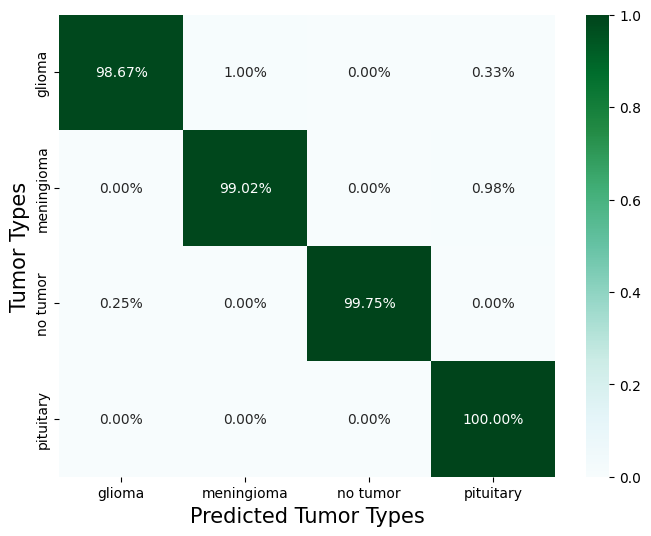

In [111]:
# Plot confusion matrix as a heatmap with percentages
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='.2%', cmap='BuGn', xticklabels=['glioma', 'meningioma', 'no tumor', 'pituitary'], yticklabels=['glioma', 'meningioma', 'no tumor', 'pituitary'])

# Customizing the title and labels
#plt.title("Custom Title", fontsize=20, color='blue', loc='left', pad=20)
plt.xlabel("Predicted Tumor Types", fontsize=15, color='black')
plt.ylabel("Tumor Types", fontsize=15, color='black')
plt.show()

In [31]:
# Evaluate the model
#test_loss, test_accuracy = model.evaluate(test_generator)
#print("Test Accuracy:", test_accuracy)

In [22]:
from sklearn.metrics import classification_report

In [144]:
report = classification_report(y_test, y_pred,  digits=3)


# Print or display the classification report
print(report)

              precision    recall  f1-score   support

           0      0.997     0.987     0.992       300
           1      0.990     0.990     0.990       306
           2      1.000     0.998     0.999       405
           3      0.987     1.000     0.993       300

    accuracy                          0.994      1311
   macro avg      0.993     0.994     0.993      1311
weighted avg      0.994     0.994     0.994      1311



# Analysing the 8 missclassified images

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix

41/41 ━━━━━━━━━━━━━━━━━━━━ 96s 2s/step
Confusion Matrix:
 [[296   3   0   1]
 [  0 303   0   3]
 [  1   0 404   0]
 [  0   0   0 300]]
Misclassified indices: [107 235 259 268 453 456 597 710]


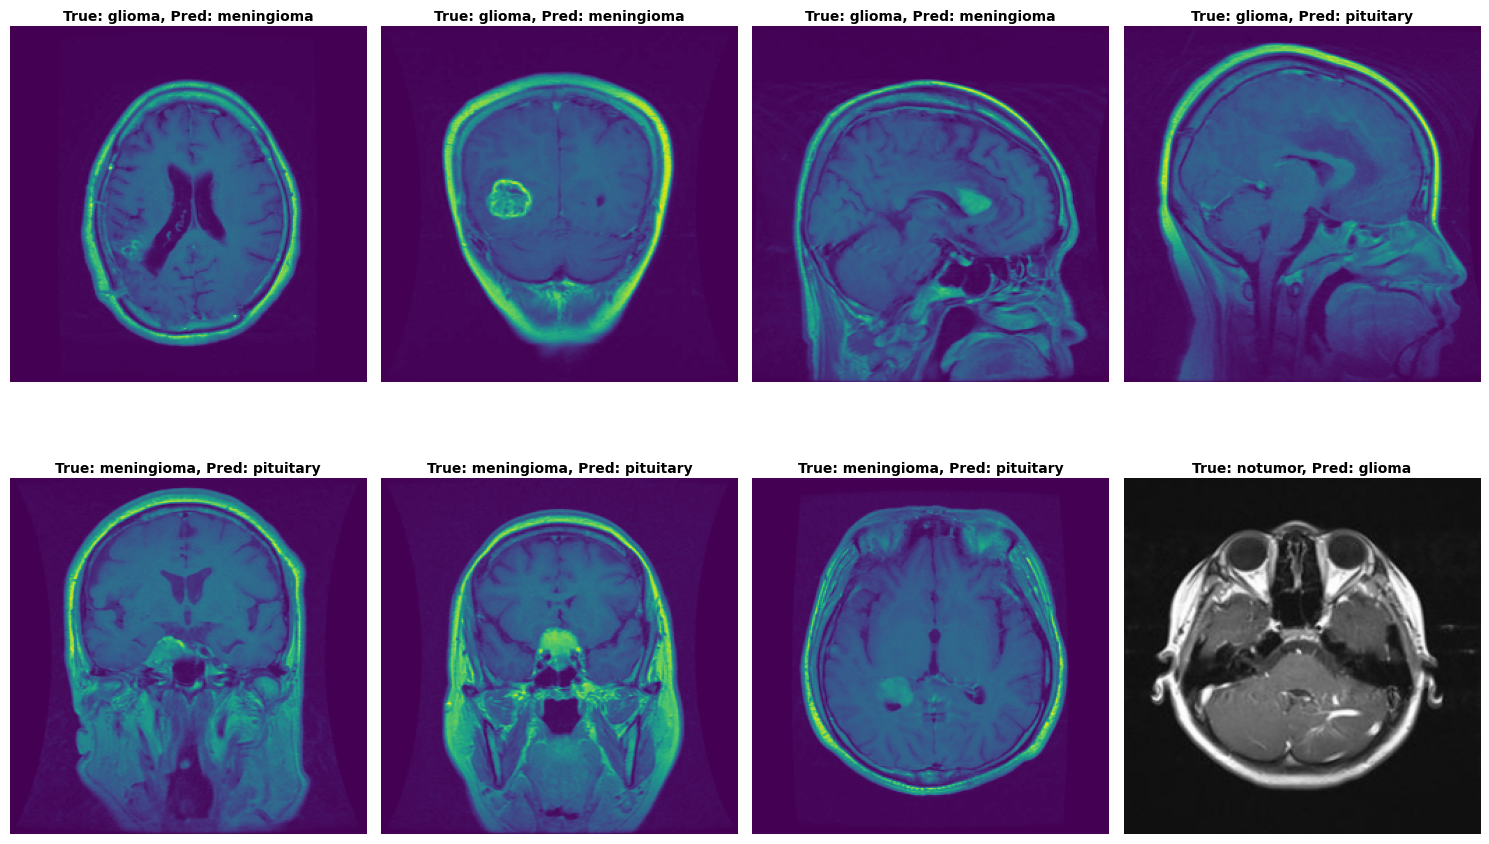

In [157]:
#Pipeline



# ImageDataGenerator setup
#test_datagen = ImageDataGenerator(rescale=1./255)
#test_generator = test_datagen.flow_from_directory(
    #'path_to_test_data',  # Adjust path
    #target_size=(64, 64),  # Adjust as per your image dimensions
    #batch_size=32,
    #class_mode='categorical',
    #shuffle=False)

# Get the filenames and true labels
filenames = test_generator.filenames
y_true = test_generator.classes
class_labels = list(test_generator.class_indices.keys())
num_samples = len(filenames)

# Make predictions
steps = int(np.ceil(num_samples / test_generator.batch_size))
y_pred = model.predict(test_generator, steps=steps)
y_pred_classes = np.argmax(y_pred, axis=1)

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)
print("Confusion Matrix:\n", cm)

# Identify misclassified instances
misclassified_indices = np.where(y_pred_classes != y_true)[0]
print("Misclassified indices:", misclassified_indices)

# Plot misclassified images # Activate the 3 line below in case you have many missclassified images would like to plot just some
#num_images_to_plot = 10 
#if len(misclassified_indices) > num_images_to_plot:
    #misclassified_indices = misclassified_indices[:num_images_to_plot]

# Plot misclassified images
# If we want to plot all: Since you have a total of 8 misclassified images: Active the line below
num_images_to_plot = len(misclassified_indices)    

plt.figure(figsize=(15, 10))
for i, index in enumerate(misclassified_indices):
    plt.subplot(2, 4, i + 1)  # Use 2 rows and 4 columns for 8 images
    img_path = filenames[index]
    img = plt.imread(os.path.join('Testing', img_path))  # Correctly join the path Here Testing is the directory where the test images are stored
    img = cv2.resize(img, (256,256))
    plt.imshow(img)
    #plt.title(f"True: {class_labels[y_true[index]]}\nPred: {class_labels[y_pred_classes[index]]}")
    title = "True: {}, Pred: {}".format(class_labels[y_true[index]], class_labels[y_pred_classes[index]])
    plt.title(title, fontdict={'fontsize': 10, 'fontweight': 'bold'}, loc='center', pad=4)
    
    plt.axis('off')
plt.tight_layout()
plt.show()

 Probabilistic Outputs :To inspect the prediction confidence and probabilistic outputs:

Image: glioma/Te-gl_0107.jpg
Class: glioma, Probability: 0.3277
Class: meningioma, Probability: 0.5126
Class: notumor, Probability: 0.0211
Class: pituitary, Probability: 0.1386


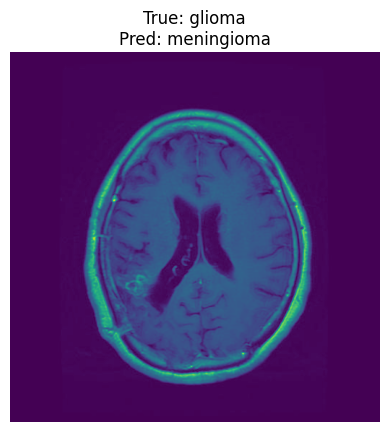

Image: glioma/Te-gl_0235.jpg
Class: glioma, Probability: 0.3312
Class: meningioma, Probability: 0.6407
Class: notumor, Probability: 0.0140
Class: pituitary, Probability: 0.0141


Image: glioma/Te-gl_0259.jpg
Class: glioma, Probability: 0.0038
Class: meningioma, Probability: 0.9922
Class: notumor, Probability: 0.0017
Class: pituitary, Probability: 0.0023


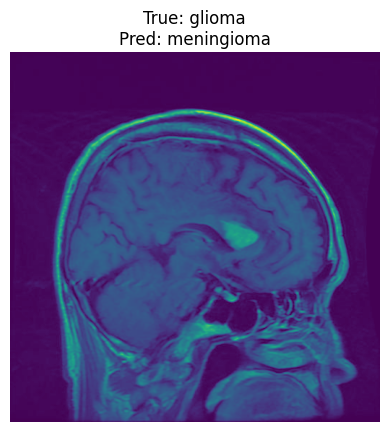

Image: glioma/Te-gl_0268.jpg
Class: glioma, Probability: 0.1080
Class: meningioma, Probability: 0.0110
Class: notumor, Probability: 0.0044
Class: pituitary, Probability: 0.8766


Image: meningioma/Te-me_0153.jpg
Class: glioma, Probability: 0.0144
Class: meningioma, Probability: 0.2068
Class: notumor, Probability: 0.0068
Class: pituitary, Probability: 0.7720


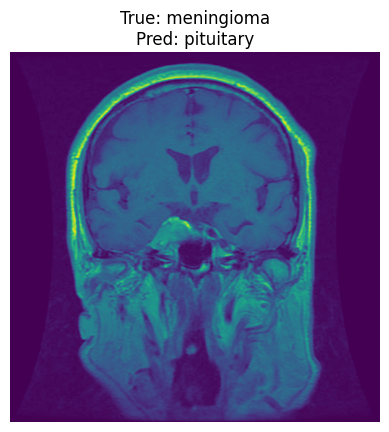

Image: meningioma/Te-me_0156.jpg
Class: glioma, Probability: 0.0037
Class: meningioma, Probability: 0.0068
Class: notumor, Probability: 0.0017
Class: pituitary, Probability: 0.9878


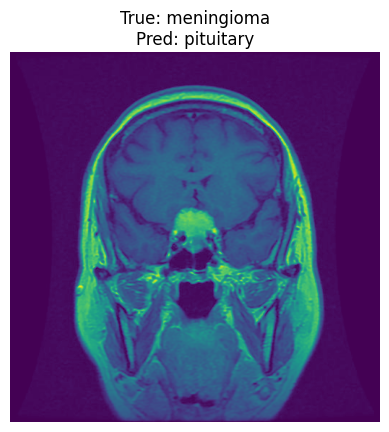

Image: meningioma/Te-me_0297.jpg
Class: glioma, Probability: 0.0150
Class: meningioma, Probability: 0.3270
Class: notumor, Probability: 0.0061
Class: pituitary, Probability: 0.6519


Image: notumor/Te-no_0104.jpg
Class: glioma, Probability: 0.4153
Class: meningioma, Probability: 0.0785
Class: notumor, Probability: 0.2020
Class: pituitary, Probability: 0.3042


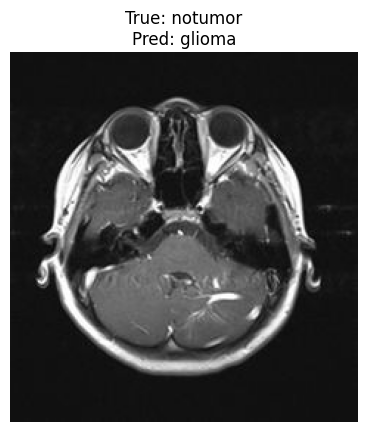

In [158]:
for i, index in enumerate(misclassified_indices):
    img_path = filenames[index]
    img = plt.imread(os.path.join('Testing', img_path))
    plt.imshow(img)
    plt.title(f"True: {class_labels[y_true[index]]}\nPred: {class_labels[y_pred_classes[index]]}")
    plt.axis('off')
    
    # Print probabilistic outputs
    probas = y_pred[index]
    print(f"Image: {img_path}")
    for class_label, proba in zip(class_labels, probas):
        print(f"Class: {class_label}, Probability: {proba:.4f}")
    plt.show()

Saliency Maps with Grad-CAM
Grad-CAM can help visualize the areas the model is focusing on. Example using Grad-CAM:

In [162]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import cv2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix

Found 1311 images belonging to 4 classes.


/Users/boubacartanda/neuefische/capstone_project/.venv/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


41/41 ━━━━━━━━━━━━━━━━━━━━ 90s 2s/step
Confusion Matrix:
 [[296   3   0   1]
 [  0 303   0   3]
 [  1   0 404   0]
 [  0   0   0 300]]
Misclassified indices: [107 235 259 268 453 456 597 710]


/var/folders/gv/vh2gkyf179nd_pv4_sl8f_300000gn/T/ipykernel_19881/2647769046.py:78: RuntimeWarning: invalid value encountered in cast
  heatmap = np.uint8(255 * heatmap)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


/var/folders/gv/vh2gkyf179nd_pv4_sl8f_300000gn/T/ipykernel_19881/2647769046.py:92: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(2, 4, i + 1)  # Use 2 rows and 4 columns for 8 images
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


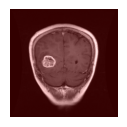

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


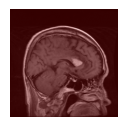

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


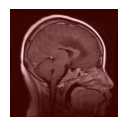

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


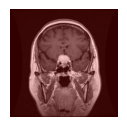

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


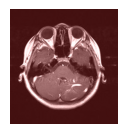

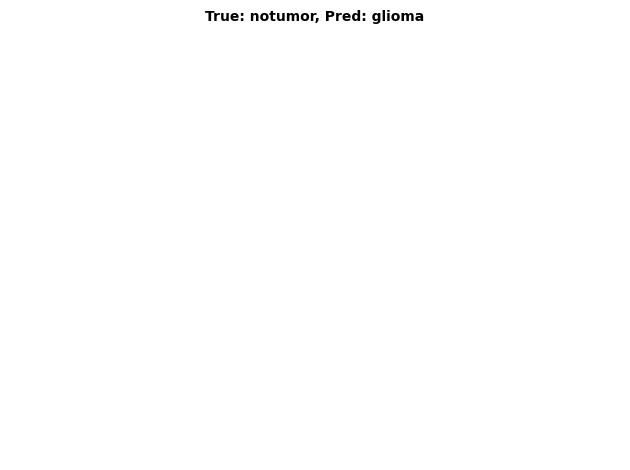

In [166]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import cv2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix

# Preprocessing function
def grayscale_to_rgb_resize(image, target_size=(256, 256)):
    # Check if the image is grayscale (single channel)
    if len(image.shape) == 2 or (len(image.shape) == 3 and image.shape[2] == 1):
        # Replicate the grayscale channel across all three RGB channels
        rgb_image = np.repeat(image[:, :, np.newaxis], 3, axis=2)
    elif len(image.shape) == 3 and image.shape[2] == 3:
        # Image is already RGB
        rgb_image = image
    else:
        raise ValueError("Unsupported image format. Image must be grayscale or RGB.")

    # Resize the image to the target size
    resized_image = cv2.resize(rgb_image, (target_size[1], target_size[0]))

    return resized_image

# Path to the directory containing the 'Testing' folder
path_to_test_data = 'Testing'  # Adjust this to the correct parent path

# ImageDataGenerator setup
test_datagen = ImageDataGenerator(rescale=1./255, preprocessing_function=grayscale_to_rgb_resize)
test_generator = test_datagen.flow_from_directory(
    path_to_test_data,
    target_size=(256, 256),  # Adjust as per your model's input dimensions
    batch_size=32,
    class_mode='categorical',
    shuffle=False)

# Get the filenames and true labels
filenames = test_generator.filenames
y_true = test_generator.classes
class_labels = list(test_generator.class_indices.keys())
num_samples = len(filenames)

# Make predictions
steps = int(np.ceil(num_samples / test_generator.batch_size))
y_pred = model.predict(test_generator, steps=steps)
y_pred_classes = np.argmax(y_pred, axis=1)

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)
print("Confusion Matrix:\n", cm)

# Identify misclassified instances
misclassified_indices = np.where(y_pred_classes != y_true)[0]
print("Misclassified indices:", misclassified_indices)

# Grad-CAM Function
def get_gradcam_heatmap(model, img_array, class_index, last_conv_layer_name):
    grad_model = tf.keras.models.Model(
        [model.input], [model.get_layer(last_conv_layer_name).output, model.output]
    )
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        loss = predictions[:, class_index]

    grads = tape.gradient(loss, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

def display_gradcam(img_path, heatmap, alpha=0.4):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    superimposed_img = heatmap * alpha + img
    plt.imshow(superimposed_img / 255)
    plt.axis('off')
    plt.show()

# Display misclassified images with Grad-CAM heatmap
last_conv_layer_name = "conv_7b_ac"  # Adjust to your model's last conv layer name

plt.figure(figsize=(15, 10))
for i, index in enumerate(misclassified_indices):
    if i >= 8:
        break
    plt.subplot(2, 4, i + 1)  # Use 2 rows and 4 columns for 8 images
    img_path = os.path.join(path_to_test_data, filenames[index])
    img = plt.imread(img_path)  # Correctly join the path
    
    # Preprocess the image using the same function used during training
    img_preprocessed = grayscale_to_rgb_resize(img, target_size=(256, 256))
    img_array = tf.keras.preprocessing.image.img_to_array(img_preprocessed)
    img_array = np.expand_dims(img_array, axis=0)
    
    heatmap = get_gradcam_heatmap(model, img_array, y_pred_classes[index], last_conv_layer_name)
    display_gradcam(img_path, heatmap)
    
    title = "True: {}, Pred: {}".format(class_labels[y_true[index]], class_labels[y_pred_classes[index]])
    plt.title(title, fontdict={'fontsize': 10, 'fontweight': 'bold'}, loc='center', pad=10)
    plt.axis('off')
plt.tight_layout()
plt.show()


# 7. Train

# 8. Plot Performance

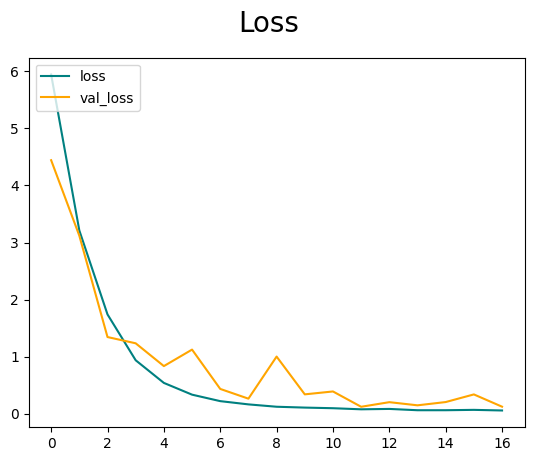

In [32]:
fig = plt.figure()
plt.plot(history.history['loss'], color='teal', label='loss')
plt.plot(history.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

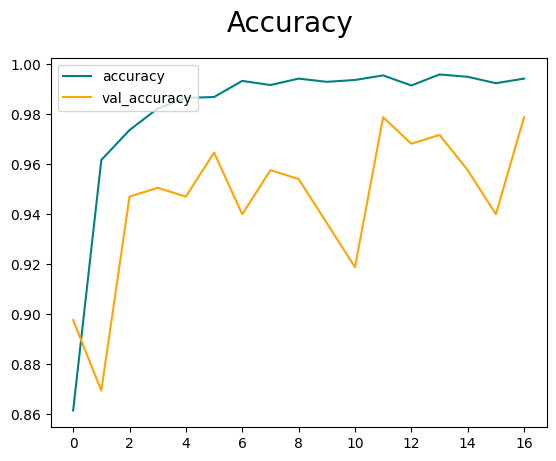

In [33]:
fig = plt.figure()
plt.plot(history.history['accuracy'], color='teal', label='accuracy')
plt.plot(history.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

# 9. Evaluate

In [34]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

pre = Precision()
re = Recall()
acc = BinaryAccuracy()

for batch in test.as_numpy_iterator(): 
    X, y = batch
    yhat = model.predict(X)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)

print(pre.result(), re.result(), acc.result())

# 10. Test

In [35]:
import cv2

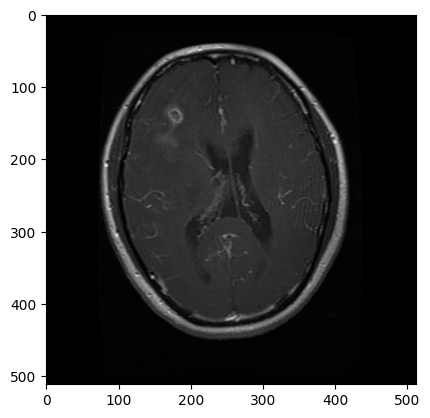

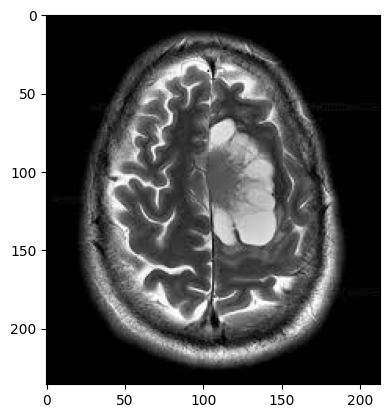

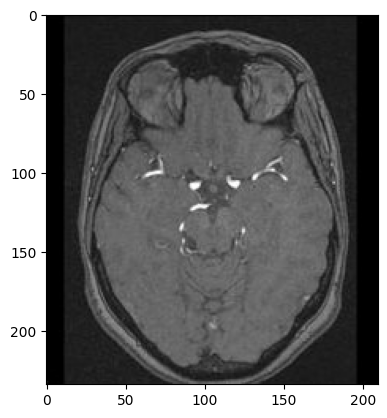

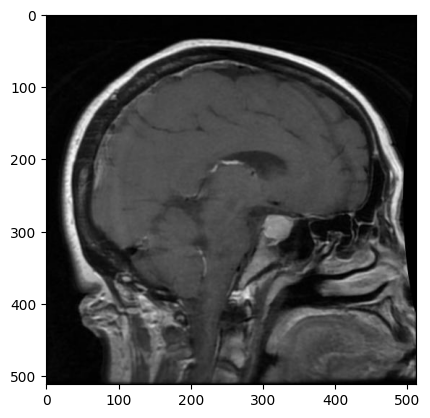

In [36]:
# Let#s try the model on unseen images

img0 = cv2.imread('/Users/boubacartanda/neuefische/capstone_project/Training/glioma/Tr-gl_0085.jpg')
#img1 = cv2.imread('/Users/boubacartanda/neuefische/capstone_project/Testing/meningioma/Te-me_0100.jpg')
#---------for a reason, the image Te-me_0100.jpg is wrongly missclassified by the previous models event the most performant on
#---------But by selecting anther image Te-me_0100, it got the four classes coorectly predicted
img1 = cv2.imread('/Users/boubacartanda/neuefische/capstone_project/Testing/meningioma/Te-me_0112.jpg')
img2 = cv2.imread('/Users/boubacartanda/neuefische/capstone_project/Testing/notumor/Te-no_0079.jpg')
img3 = cv2.imread('/Users/boubacartanda/neuefische/capstone_project/Testing/pituitary/Te-pi_0116.jpg')




plt.imshow(img0)
plt.show()
plt.imshow(img1)
plt.show()
plt.imshow(img2)
plt.show()
plt.imshow(img3)
plt.show()

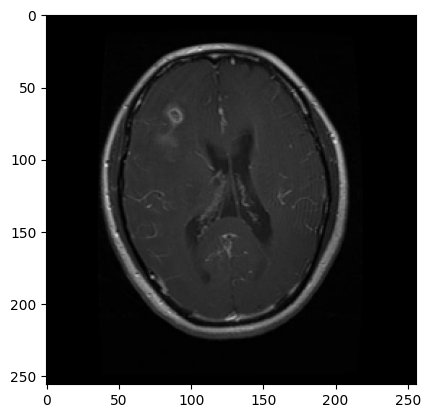

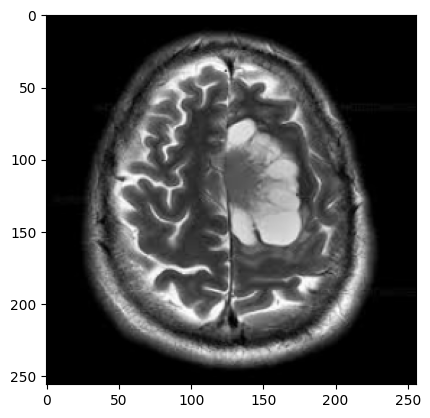

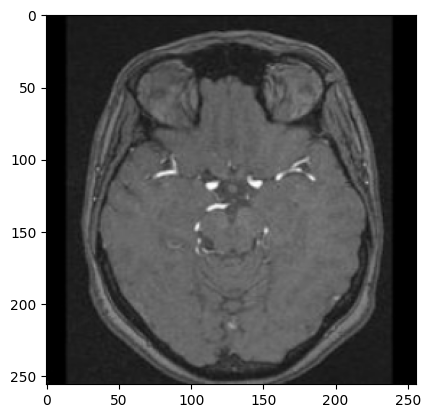

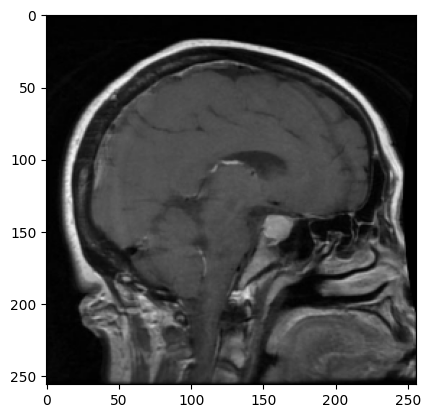

In [37]:
images = [img0, img1, img2, img3]

for i in range(len(images)):
    resize = tensorflow.image.resize(images[i], (256,256))
    images[i]=resize
    plt.imshow(images[i].numpy().astype(int))
    plt.show()

In [38]:
# Predicting the image classes for the for images in images list
yhats = []
for i in range(len(images)):
    yhat = model.predict(np.expand_dims(images[i]/255, 0)) # normalizing then predicting
    yhats.append(yhat)

yhats

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 292ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


[array([[9.9967325e-01, 1.2457209e-04, 6.4552616e-05, 1.3772368e-04]],
       dtype=float32),
 array([[7.0406141e-04, 9.9847108e-01, 5.3383230e-04, 2.9106572e-04]],
       dtype=float32),
 array([[2.7054051e-04, 2.3633425e-04, 9.9927753e-01, 2.1563529e-04]],
       dtype=float32),
 array([[1.8573468e-07, 2.5676059e-07, 2.4870417e-08, 9.9999952e-01]],
       dtype=float32)]

In [39]:
# Just trying argmax to get an impression
yhats[1].argmax(axis=1)

array([1])

In [40]:
# showing the predicted classes

for i in range(len(yhats)):
    if yhats[i].argmax(axis=1) == 0: 
        print(f'Image number {i}: Predicted class is Gioma')
    elif yhats[i].argmax(axis=1) == 1:
        print(f'Image number {i}: Predicted class is Meningioma')
    elif yhats[i].argmax(axis=1) == 2:
        print(f'Image number {i}: Predicted class is No_Tumor')
    else:
        print(f'Image number {i}: Predicted class is Pituitary')



Image number 0: Predicted class is Gioma
Image number 1: Predicted class is Meningioma
Image number 2: Predicted class is No_Tumor
Image number 3: Predicted class is Pituitary


# 11. Save the Model

In [8]:
from tensorflow.keras.models import load_model

In [42]:
#model.save(os.path.join('models','imageclassifier_20240427.h5'))

In [43]:
#new_model = load_model('imageclassifier_20240427.h5')

In [44]:
keras.models.save_model(model, 'my_model_5.keras')


In [10]:
#reloding the trained model
#reloaded_model = keras.models.load_model('my_model_5.keras')

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image 
%matplotlib inline
from IPython.display import Image


In [3]:
logo1=cv2.imread('logo1.png', cv2.IMREAD_COLOR)
logo2=cv2.imread('logo2.png', cv2.IMREAD_COLOR)

logo1=cv2.cvtColor(logo1, cv2.COLOR_BGR2RGB)
logo2=cv2.cvtColor(logo2, cv2.COLOR_BGR2RGB)

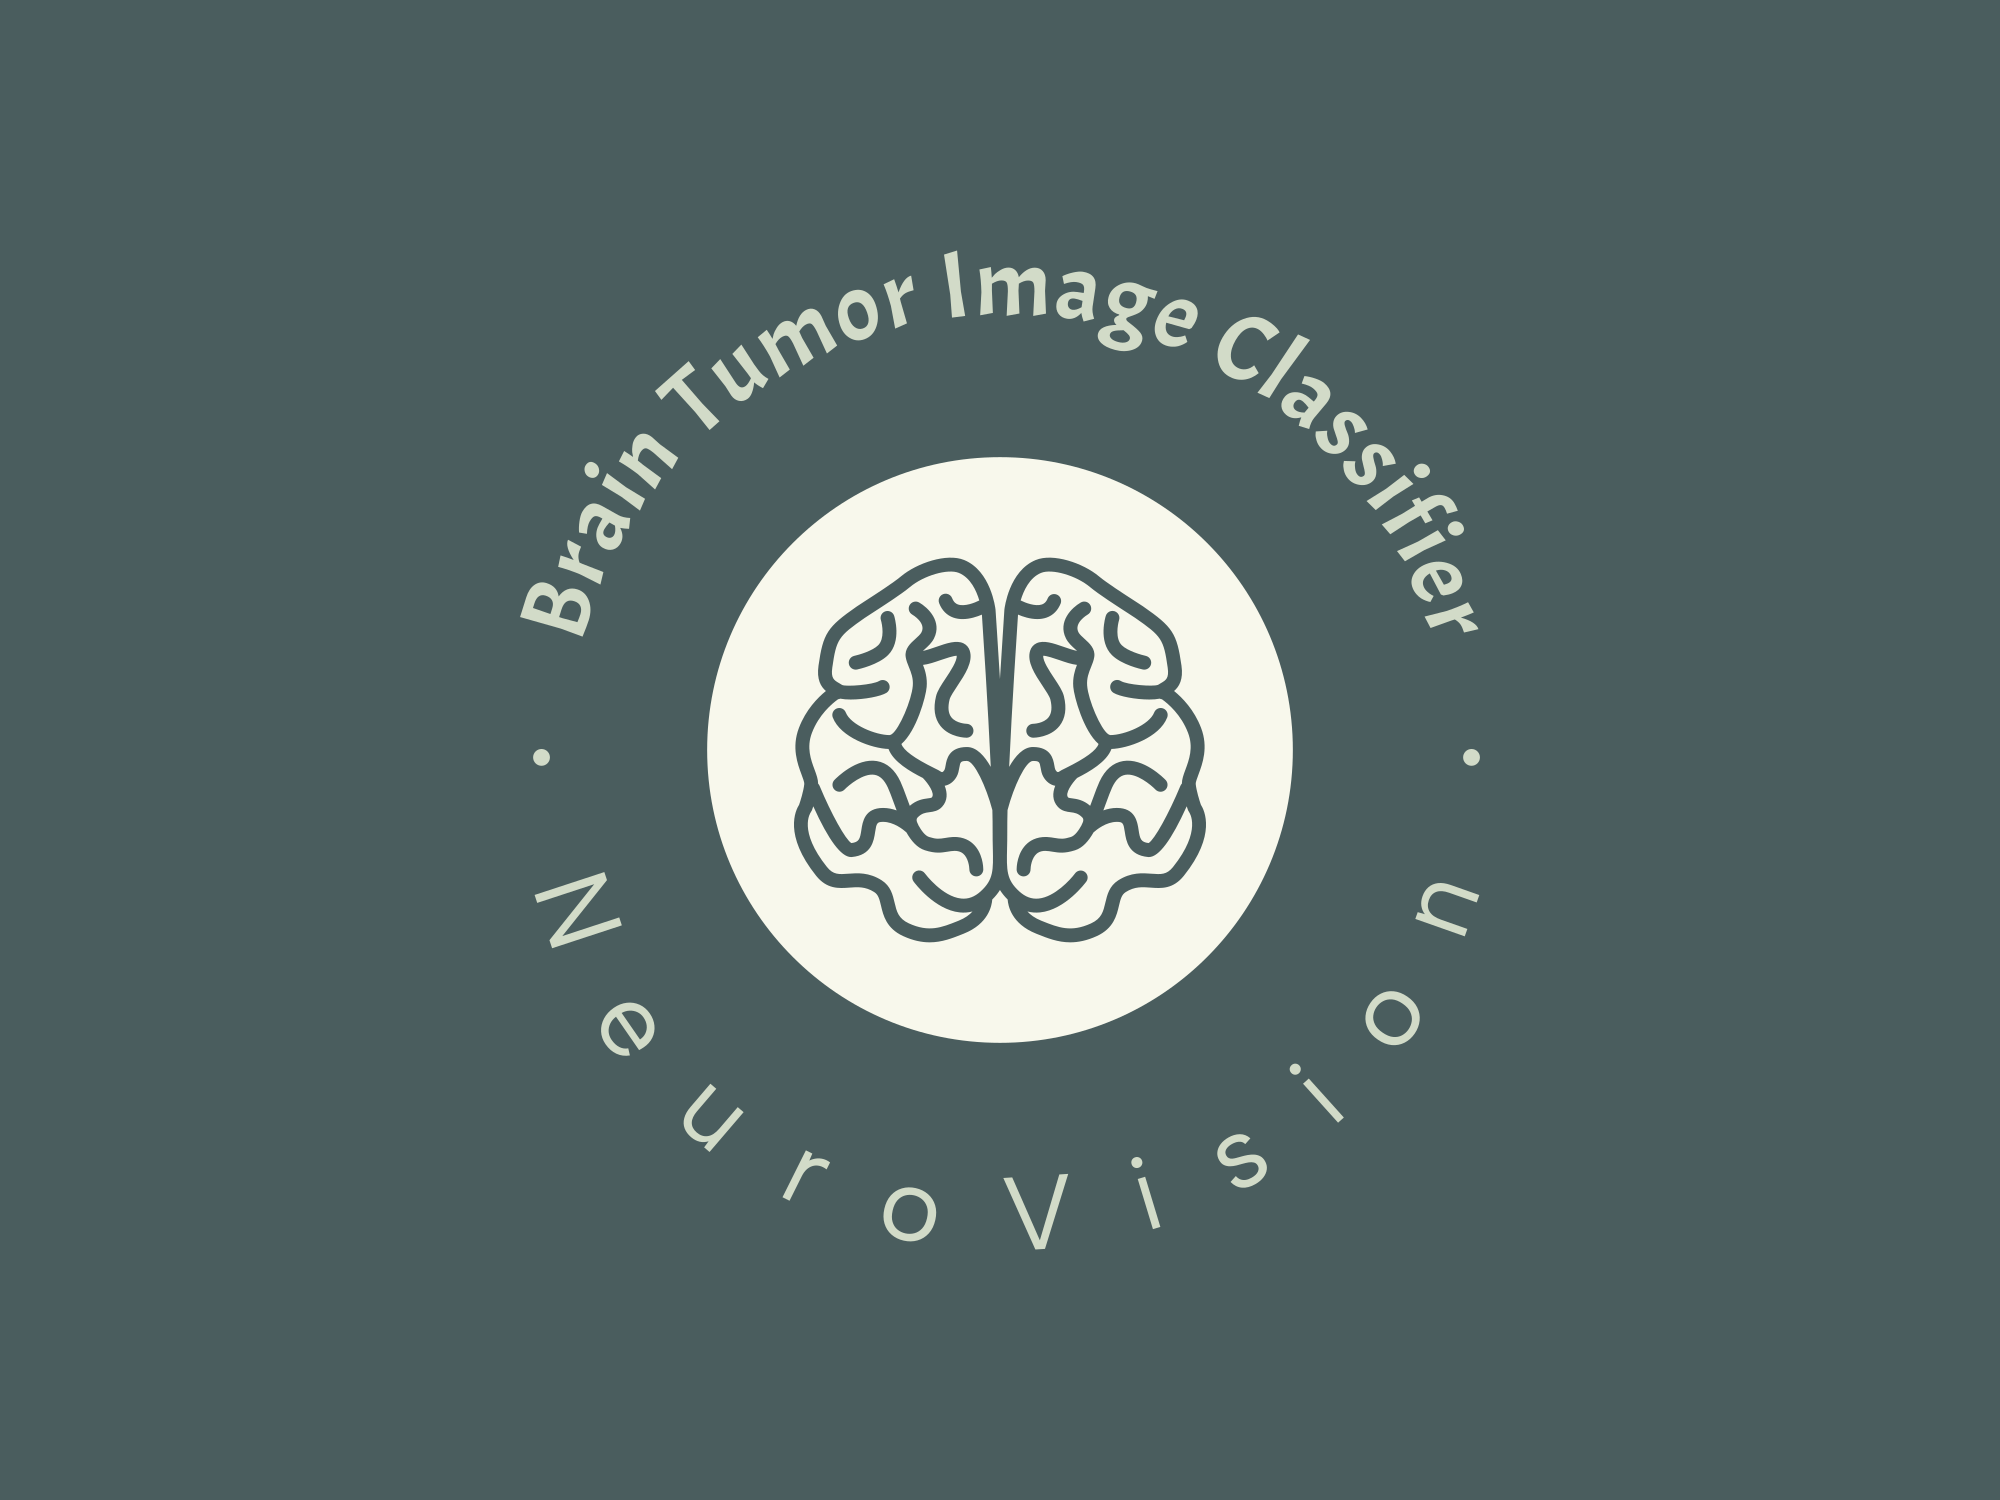

In [4]:
Image('logo1.png')

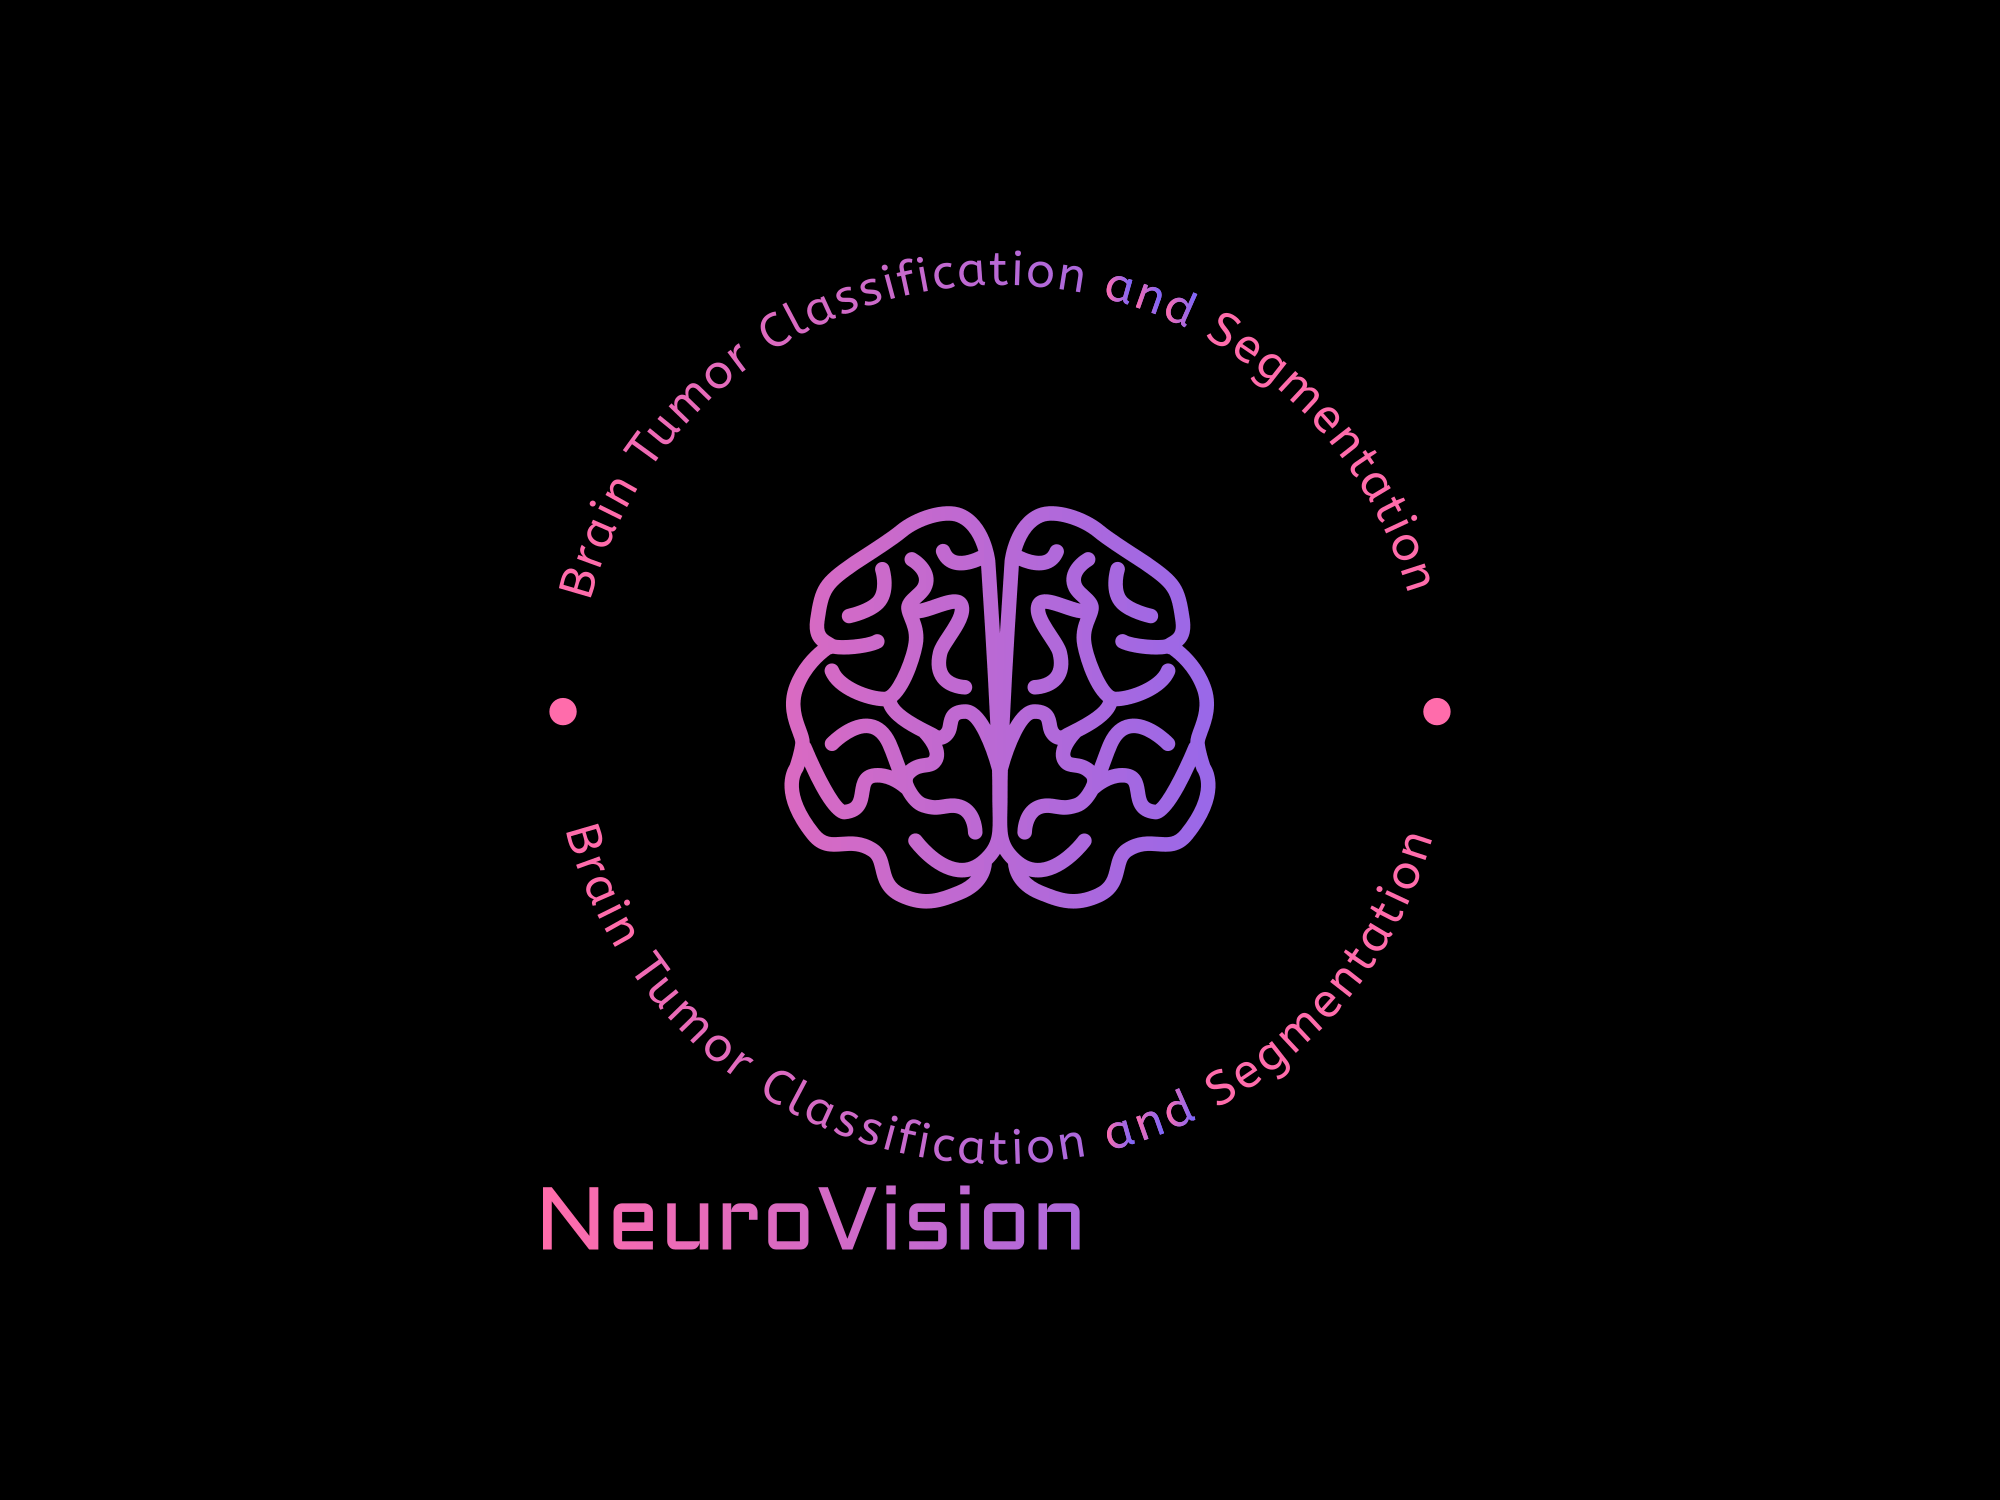

In [5]:
Image('logo2.png')

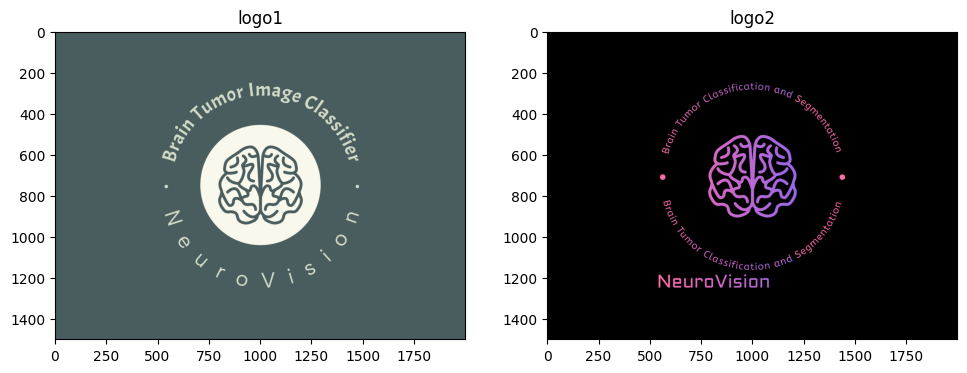

In [6]:
plt.figure(figsize=[18,5])
plt.subplot(131); plt.imshow(logo1);  plt.title("logo1");
plt.subplot(132); plt.imshow(logo2);         plt.title("logo2");

In [ ]:
#'NeuroVision'

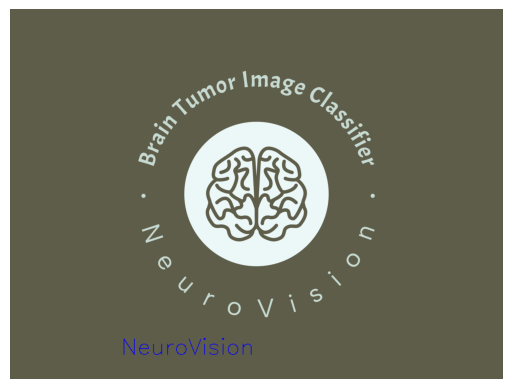

In [11]:
# Copy the image to avoid altering the original
logoblend = logo1.copy()

# Specify the text and its properties
text = 'Neuro'  
position = (450, 1400)  # Position where the text will appear
font = cv2.FONT_HERSHEY_SIMPLEX
font_scale = 3  # Font scale factor
color = (255, 0, 0)  # Text color in BGR (here, blue)
thickness = 2  # Thickness of the text

# Add text to the image
cv2.putText(logoblend, text, position, font, font_scale, color, thickness)

# Convert the image from BGR to RGB
logoblend_rgb = cv2.cvtColor(logoblend, cv2.COLOR_BGR2RGB)

# Display the annotated image using matplotlib
plt.imshow(logoblend_rgb)
plt.axis('off')  # Hide axis
plt.show()


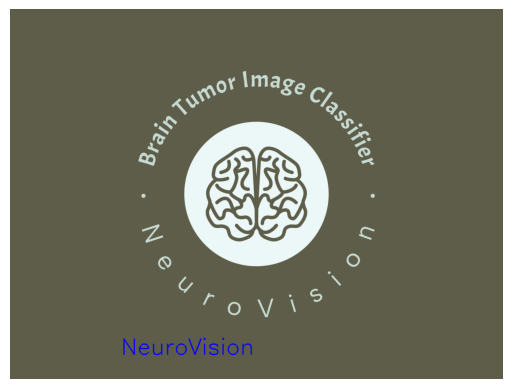

In [26]:
# Create a copy to avoid altering the original image
logoblend = logo1.copy()

# Define the background color (assuming white background)
background_color = [255, 255, 255]  # White

# Define the new background color
new_background_color = [0, 0, 0]  # Black

# Change background color
# Create a mask where the white background is
mask = cv2.inRange(logoblend, np.array(background_color) - 10, np.array(background_color) + 10)

# Change the background color to black
logoblend[mask == 255] = new_background_color

# Specify the text and its properties
text = 'NeuroVision'
position = (450, 1400)  # Position where the text will appear
font = cv2.FONT_HERSHEY_SIMPLEX
font_scale = 3  # Font scale factor
color = (255, 0, 0)  # Text color in BGR (here, blue)
thickness = 4  # Thickness of the text

# Add text to the image
cv2.putText(logoblend, text, position, font, font_scale, color, thickness)

# Convert the image from BGR to RGB
logoblend_rgb = cv2.cvtColor(logoblend, cv2.COLOR_BGR2RGB)

# Display the annotated image using matplotlib
plt.imshow(logoblend_rgb)
plt.axis('off')  # Hide axis
plt.show()


In [189]:
logo1.shape

(1500, 2000, 3)

In [190]:
logo2.shape

(1500, 2000, 3)

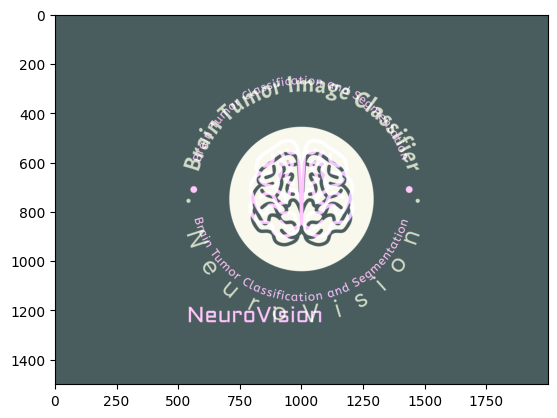

In [191]:
# Method 1: Direct Addition
added_image = cv2.add(logo1, logo2)
plt.imshow(added_image)
plt.show()

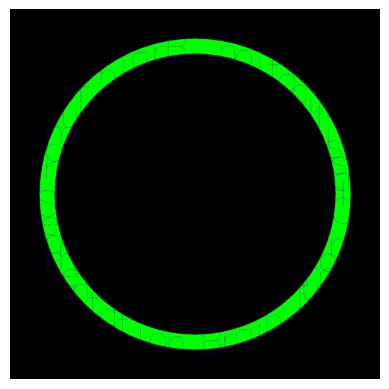

In [24]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import math

# Create a blank image
image_size = 1500
logo = np.zeros((image_size, image_size, 3), dtype=np.uint8)

# Define circle properties
center = (image_size // 2, image_size // 2)  # Center of the circle
radius = 600  # Radius of the circle
circle_color = (0, 255, 0)  # Circle color (Green)
circle_thickness = 60  # Thickness of the circle border

# Draw the circle
cv2.circle(logo, center, radius, circle_color, circle_thickness)

# Define text properties
upper_text = 'Brain Tumor Classification '
lower_text = 'Brain Tumor Segmentation'
font = cv2.FONT_HERSHEY_SIMPLEX
font_scale = 5
text_color = (255, 0, 0)  # Text color (Blue)
text_thickness = 1

# Function to draw text along the upper half of the circle
def draw_text_on_arc(image, text, center, radius, angle_offset, font, font_scale, text_color, text_thickness):
    angle_step = 180 / (len(text) + 1)
    for i, char in enumerate(text):
        angle = angle_offset + (i + 1) * angle_step
        x = int(center[0] + radius * math.cos(math.radians(angle)))
        y = int(center[1] - radius * math.sin(math.radians(angle)))
        (text_width, text_height), _ = cv2.getTextSize(char, font, font_scale, text_thickness)
        text_x = x - text_width // 2
        text_y = y + text_height // 2
        cv2.putText(image, char, (text_x, text_y), font, font_scale, text_color, text_thickness)

# Draw the upper text on the upper half of the circle
draw_text_on_arc(logo, upper_text, center, radius, -90, font, font_scale, text_color, text_thickness)

# Draw the lower text on the lower half of the circle
draw_text_on_arc(logo, lower_text, center, radius, 90, font, font_scale, text_color, text_thickness)

# Display the logo using matplotlib
plt.imshow(cv2.cvtColor(logo, cv2.COLOR_BGR2RGB))
plt.axis('off')  # Hide axis
plt.show()


In [40]:
logo1=cv2.imread('logo1.png', cv2.IMREAD_COLOR)
logo2=cv2.imread('logo2.png', cv2.IMREAD_COLOR)

logo1=cv2.cvtColor(logo1, cv2.COLOR_BGR2RGB)
logo2=cv2.cvtColor(logo2, cv2.COLOR_BGR2RGB)

In [49]:
import cv2
import numpy as np

def create_background_with_logos(background_color, logo_path, output_path, width=1920, height=1080, num_logos_x=2, num_logos_y=2):
    # Create a blank image with the specified background color
    background = np.full((height, width, 3), background_color, dtype=np.uint8)

    # Load the logo image
    logo = cv2.imread(logo_path, cv2.IMREAD_UNCHANGED)
    
    if logo is None:
        print("Error: Logo image not found.")
        return

    # Resize the logo to fit within the grid
    logo_height, logo_width = logo.shape[:2]
    max_logo_width = width // num_logos_x
    max_logo_height = height // num_logos_y
    scaling_factor = min(max_logo_width / logo_width, max_logo_height / logo_height)
    logo = cv2.resize(logo, (0, 0), fx=scaling_factor, fy=scaling_factor)
    logo_height, logo_width = logo.shape[:2]

    # Compute the space between logos
    x_spacing = (width - (num_logos_x * logo_width)) // (num_logos_x + 1)
    y_spacing = (height - (num_logos_y * logo_height)) // (num_logos_y + 1)

    # Place logos on the background
    for i in range(num_logos_y):
        for j in range(num_logos_x):
            x = x_spacing + j * (logo_width + x_spacing)
            y = y_spacing + i * (logo_height + y_spacing)
            
            # Overlay the logo on the background
            if logo.shape[2] == 4:  # If the logo has an alpha channel
                alpha_logo = logo[:, :, 3] / 255.0
                alpha_background = 1.0 - alpha_logo
                
                for c in range(0, ):
                    background[y:y+logo_height, x:x+logo_width, c] = (alpha_logo * logo[:, :, c] +
                                                                      alpha_background * background[y:y+logo_height, x:x+logo_width, c])
            else:
                background[y:y+logo_height, x:x+logo_width] = logo

    # Save the output image
    cv2.imwrite(output_path, background)
    print(f"Background image saved to {output_path}")

# Example usage
background_color1 = (0, 0, 0)  # White background
background_color2 = (0, 0, 0)  # White background

logo_path1 = 'logo1.png'  # Path to the logo image with transparency (if available)
logo_path2 = 'logo2.png'  # Path to the logo image with transparency (if available)

output_path1 = 'background_with_logos1.png'  # Output file path
output_path2= 'background_with_logos2.png'  # Output file path


create_background_with_logos(background_color1, logo_path1, output_path1)
create_background_with_logos(background_color2, logo_path2, output_path2)



Background image saved to background_with_logos1.png
Background image saved to background_with_logos2.png


In [51]:
import cv2
import numpy as np

def create_background_with_logos(background_color, logo_path, output_path, width=1920, height=1080):
    # Create a blank image with the specified background color
    background = np.full((height, width, 3), background_color, dtype=np.uint8)

    # Load the logo image
    logo = cv2.imread(logo_path, cv2.IMREAD_UNCHANGED)
    
    if logo is None:
        print("Error: Logo image not found.")
        return

    # Resize the logo to fit within the grid
    logo_height, logo_width = logo.shape[:2]
    max_logo_width = width // 2
    max_logo_height = height // 2
    scaling_factor = min(max_logo_width / logo_width, max_logo_height / logo_height)
    logo = cv2.resize(logo, (0, 0), fx=scaling_factor, fy=scaling_factor)
    logo_height, logo_width = logo.shape[:2]

    # Calculate the positions for the two diagonal logos
    positions = [
        (0, 0),  # Top-left corner
        (width - logo_width, height - logo_height)  # Bottom-right corner
    ]

    # Place logos on the background
    for (x, y) in positions:
        # Overlay the logo on the background
        if logo.shape[2] == 4:  # If the logo has an alpha channel
            alpha_logo = logo[:, :, 3] / 255.0
            alpha_background = 1.0 - alpha_logo
            
            for c in range(0, 3):
                background[y:y+logo_height, x:x+logo_width, c] = (alpha_logo * logo[:, :, c] +
                                                                  alpha_background * background[y:y+logo_height, x:x+logo_width, c])
        else:
            background[y:y+logo_height, x:x+logo_width] = logo

    # Save the output image
    cv2.imwrite(output_path, background)
    print(f"Background image saved to {output_path}")

# Example usage
background_color1 = (0, 0, 0)  # White background
background_color2 = (0, 0, 0)  # White background

logo_path1 = 'logo1.png'  # Path to the logo image with transparency (if available)
logo_path2 = 'logo2.png'  # Path to the logo image with transparency (if available)

output_path1 = 'background_with_logos1.png'  # Output file path
output_path2= 'background_with_logos2.png'  # Output file path


create_background_with_logos(background_color1, logo_path1, output_path1)
create_background_with_logos(background_color2, logo_path2, output_path2)


Background image saved to background_with_logos1.png
Background image saved to background_with_logos2.png


In [71]:
import cv2
import numpy as np

def create_background_with_logo(background_color, logo_path, output_path, width=1920, height=1080):
    # Create a blank image with the specified background color
    background = np.full((height, width, 3), background_color, dtype=np.uint8)

    # Load the logo image
    logo = cv2.imread(logo_path, cv2.IMREAD_UNCHANGED)
    
    if logo is None:
        print("Error: Logo image not found.")
        return

    # Resize the logo to be a bit larger
    logo_height, logo_width = logo.shape[:2]
    scaling_factor = 0.5  # Adjust this factor to change the size of the logo
    logo = cv2.resize(logo, (0, 0), fx=scaling_factor, fy=scaling_factor)
    logo_height, logo_width = logo.shape[:2]

    # Position for the logo in the top-left corner
    x = 0  # Adjust the x-offset
    y = 0 # Adjust the y-offset

    # Overlay the logo on the background
    if logo.shape[2] == 4:  # If the logo has an alpha channel
        alpha_logo = logo[:, :, 3] / 255.0
        alpha_background = 1.0 - alpha_logo
        
        for c in range(0, 3):
            background[y:y+logo_height, x:x+logo_width, c] = (alpha_logo * logo[:, :, c] +
                                                              alpha_background * background[y:y+logo_height, x:x+logo_width, c])
    else:
        background[y:y+logo_height, x:x+logo_width] = logo

    # Save the output image
    cv2.imwrite(output_path, background)
    print(f"Background image saved to {output_path}")

# Example usage
background_color = (0, 0, 0)  # Black background
logo_path = 'logo2.png'  # Path to the logo image with transparency (if available)
output_path = 'background_with_logo2one222.png'  # Output file path

create_background_with_logo(background_color, logo_path, output_path)


Background image saved to background_with_logo2one222.png


In [69]:
background_with_logo2one2=cv2.imread('background_with_logo2one.png', cv2.IMREAD_COLOR)

background_with_logo2one2=cv2.cvtColor(background_with_logo2one2, cv2.COLOR_BGR2RGB)

Text(0.5, 1.0, 'logo1')

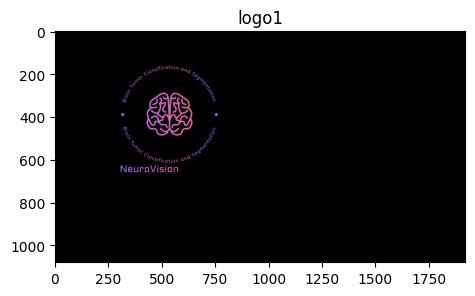

In [70]:
plt.figure(figsize=[18,5])
plt.subplot(131); plt.imshow(background_with_logo2one2);  plt.title("logo1")


In [66]:
background_with_logo2one = cv2.imread('background_with_logo2one')

cv2.imshow(background_with_logo2one)

[ WARN:0@54841.144] global loadsave.cpp:248 findDecoder imread_('background_with_logo2one'): can't open/read file: check file path/integrity


error: OpenCV(4.9.0) :-1: error: (-5:Bad argument) in function 'imshow'
> Overload resolution failed:
>  - imshow() missing required argument 'mat' (pos 2)
>  - imshow() missing required argument 'mat' (pos 2)
>  - imshow() missing required argument 'mat' (pos 2)
